In [1]:
from pathlib import Path
from typing import Any

import numpy as np
import torch

from src.geometry.point_transformation import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.splats.splats_utils import *

In [2]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Initializing covariances for Gaussian Splats 

In the paper they initialize covariances as isotropic with axes equal to the distance to the 3 nearest neighbours. But for now I initialized it from uniform distribution



In [3]:
diagonal = np.array([[1.0, 0, 0], [0, 1.0, 0], [0, 0, 1.0]])

def init_from_uniform(n):
    covs = np.zeros((n, 3, 3), dtype=np.float32)
    vals = np.random.uniform(low=4.0, high=5.0, size=n)
    covs[:, 0, 0] = vals
    covs[:, 1, 1] = vals
    covs[:, 2, 2] = vals
    return covs

In [4]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'
output_path = scene_folder / 'undistorted_images'

pcd = o3d.io.read_point_cloud(str(scene_folder / 'sparse.ply'))
# pcd.compute_mean_and_covariance()
# pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=3)) 
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)
covariances = init_from_uniform(len(points))# np.asarray(pcd.covariances)

In [5]:
covariances[0]

array([[4.643518, 0.      , 0.      ],
       [0.      , 4.643518, 0.      ],
       [0.      , 0.      , 4.643518]], dtype=float32)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
requires_grad = True

In [7]:
reconstruction = pycolmap.Reconstruction(output_path / 'sparse')

img_id = 1
img = reconstruction.images[img_id]
cam_id = 1

extrinsic_matrix = get_extrinsic_params(img.cam_from_world)
f, cx, cy = reconstruction.cameras[cam_id].params
width, height = reconstruction.cameras[cam_id].width, reconstruction.cameras[cam_id].height
znear, zfar = 1, 5
intrinsic_matrix = get_intrinsic_opengl_params(f, f, height, width, zfar=zfar, znear=znear)
W = torch.tensor(extrinsic_matrix[:3, :3].T, device=device, dtype=torch.float32) # viewing transformation

homogeneous_points = convert_to_homogenous(points)
camera_coordinates = homogeneous_points @ extrinsic_matrix.T
clip_coordinates = camera_coordinates @ intrinsic_matrix.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)

ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
c = colors[point_ids]

screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
cov_3d = torch.tensor(covariances[point_ids], device=device, dtype=torch.float32, requires_grad=True)

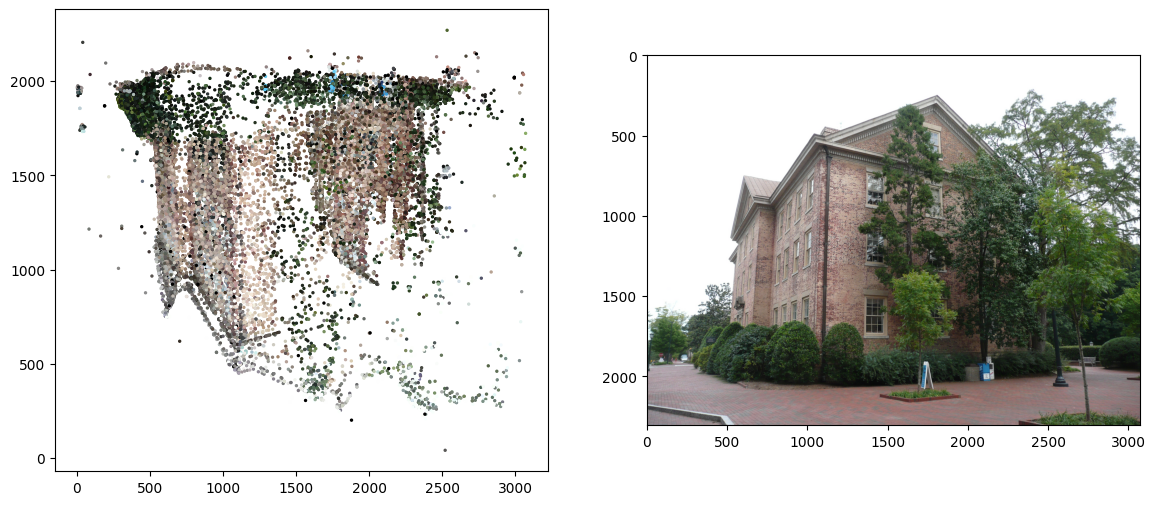

In [8]:
image = mpimg.imread(images_folder / f'{img.name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(screen_coordinates[:, 0], screen_coordinates[:, 1], s=2, c=c)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()

In [9]:
print(f"# filtered points {sum(point_ids)}")
print(f"# total points {reconstruction.num_points3D()}")

# filtered points 33008
# total points 57713


In [10]:
n = sum(point_ids)

This is how our ground truth looks like - it is an image from a given camera 

In [11]:
print("Image shape: ", image.shape)
print(image[500, 500])

Image shape:  (2304, 3072, 3)
[255 255 255]


#### Initialization

We will optimize the attributes of Gaussians:
- coordinates $[x, y, z]$ (initialized from SFM)
- color (in original paper they use SH, but I think that RGB color is simpler as for now)
- alpha = opacity
- covariance matrix

we'll use pytorch to train these parameters (even though we don't have a model)

In [12]:
points_pt = torch.tensor(screen_coordinates, requires_grad=requires_grad, device=device, dtype=torch.float32)
colors_pt = torch.tensor(c, requires_grad=requires_grad, device=device, dtype=torch.float32)
# These are really exponents applied to sigmoid function 
alphas_exponents_pt = torch.rand(n, requires_grad=requires_grad, device=device, dtype=torch.float32) * 12 - 6 

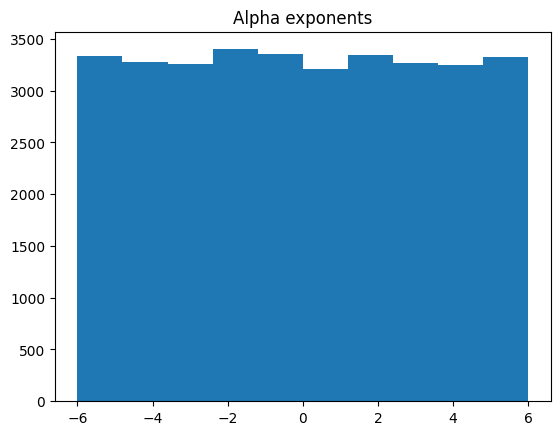

In [13]:
plt.hist(alphas_exponents_pt.detach().cpu())
_ = plt.title('Alpha exponents')

In [30]:
cov_3d

tensor([[[4.6435, 0.0000, 0.0000],
         [0.0000, 4.6435, 0.0000],
         [0.0000, 0.0000, 4.6435]],

        [[4.2044, 0.0000, 0.0000],
         [0.0000, 4.2044, 0.0000],
         [0.0000, 0.0000, 4.2044]],

        [[4.8676, 0.0000, 0.0000],
         [0.0000, 4.8676, 0.0000],
         [0.0000, 0.0000, 4.8676]],

        ...,

        [[4.0667, 0.0000, 0.0000],
         [0.0000, 4.0667, 0.0000],
         [0.0000, 0.0000, 4.0667]],

        [[4.6117, 0.0000, 0.0000],
         [0.0000, 4.6117, 0.0000],
         [0.0000, 0.0000, 4.6117]],

        [[4.8488, 0.0000, 0.0000],
         [0.0000, 4.8488, 0.0000],
         [0.0000, 0.0000, 4.8488]]], device='cuda:0', requires_grad=True)

In [36]:
eigenvalues, eigenvectors = torch.linalg.eig(cov_3d)

In [37]:
eigenvalues.real

tensor([[4.6435, 4.6435, 4.6435],
        [4.2044, 4.2044, 4.2044],
        [4.8676, 4.8676, 4.8676],
        ...,
        [4.0667, 4.0667, 4.0667],
        [4.6117, 4.6117, 4.6117],
        [4.8488, 4.8488, 4.8488]], device='cuda:0', grad_fn=<SelectBackward0>)

In [38]:
eigenvectors.real.shape

torch.Size([33008, 3, 3])

In [39]:
eigenvectors.shape

torch.Size([33008, 3, 3])

In [40]:
lower = 1e-20 # add some small value to prevent 0 as log argument

rot = eigenvectors.real

# Similarly to alphas we'll actually optimize exponents
scale = torch.sqrt(torch.abs(eigenvalues.real[:, np.newaxis])) * torch.repeat_interleave(torch.tensor(diagonal[np.newaxis, ...], device=device), n, axis=0)
scale_exponents = torch.log(scale)
scale_exponents.shape

torch.Size([33008, 3, 3])

In [41]:
rot

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        ...,

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0', grad_fn=<SelectBackward0>)

In [42]:
scale_exponents[1]

tensor([[0.7181,   -inf,   -inf],
        [  -inf, 0.7181,   -inf],
        [  -inf,   -inf, 0.7181]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)

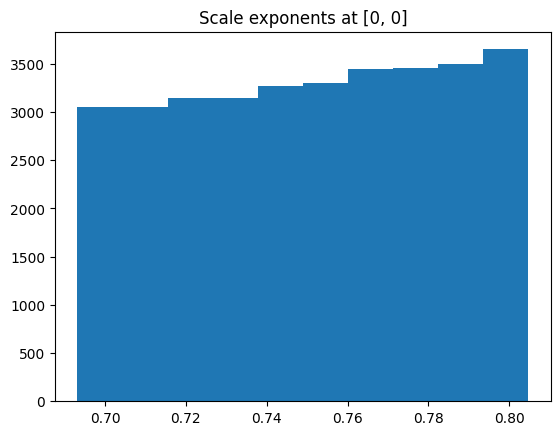

In [43]:
plt.hist(scale_exponents[:, 0, 0].detach().cpu())
# plt.hist(scale[0, 0].detach().cpu())
_ = plt.title('Scale exponents at [0, 0]')

Veryfing calculations

In [44]:
cov_3d[0] # original 3D covariance

tensor([[4.6435, 0.0000, 0.0000],
        [0.0000, 4.6435, 0.0000],
        [0.0000, 0.0000, 4.6435]], device='cuda:0', grad_fn=<SelectBackward0>)

In [45]:
eigenvals, eigenvects = torch.linalg.eig(cov_3d[3])
eigenvals, eigenvects

(tensor([4.7101+0.j, 4.7101+0.j, 4.7101+0.j], device='cuda:0',
        grad_fn=<LinalgEigBackward0>),
 tensor([[1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j]], device='cuda:0',
        grad_fn=<LinalgEigBackward0>))

In [46]:
scale_exponents[0]

tensor([[0.7677,   -inf,   -inf],
        [  -inf, 0.7677,   -inf],
        [  -inf,   -inf, 0.7677]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>)

In [47]:
torch.exp(scale_exponents[0]).dtype

torch.float64

In [48]:
rot

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        ...,

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0', grad_fn=<SelectBackward0>)

In [51]:
computed = rot[0] @ torch.exp(scale_exponents[0]).type(torch.float32) @ torch.exp(scale_exponents[0]).type(torch.float32).T @ rot[0].T

In [52]:
print("Computed: ", computed)
print("Original: ", cov_3d[0])

Computed:  tensor([[4.6435, 0.0000, 0.0000],
        [0.0000, 4.6435, 0.0000],
        [0.0000, 0.0000, 4.6435]], device='cuda:0', grad_fn=<MmBackward0>)
Original:  tensor([[4.6435, 0.0000, 0.0000],
        [0.0000, 4.6435, 0.0000],
        [0.0000, 0.0000, 4.6435]], device='cuda:0', grad_fn=<SelectBackward0>)


#### Pseudo algorithm

Below I tried to follow the steps from the paper (but some are skipped)

We can actually start training with lower resolution images (but then a new point cloud needs to be created)

In [53]:
width, height

(3072, 2304)

In [54]:
import itertools

h, w = image.shape[0], image.shape[1]
pixels = np.array(list(itertools.product(range(h), range(w))))

In [55]:
pixels[h - 10:h]

array([[   0, 2294],
       [   0, 2295],
       [   0, 2296],
       [   0, 2297],
       [   0, 2298],
       [   0, 2299],
       [   0, 2300],
       [   0, 2301],
       [   0, 2302],
       [   0, 2303]])

Filter splats that have means within a chosen tile

In [56]:
coor = 1000
tile_size = 32
tile_left_lower, tile_upper_right = np.array([coor, coor]), np.array([coor + tile_size, coor + tile_size])

In [57]:
ids = (screen_coordinates[:, 0] > tile_left_lower[0]) & (screen_coordinates[:, 1] > tile_left_lower[1]) & (screen_coordinates[:, 0] < tile_upper_right[0]) & (screen_coordinates[:, 1] < tile_upper_right[1]) 
np.sum(ids)

np.int64(15)

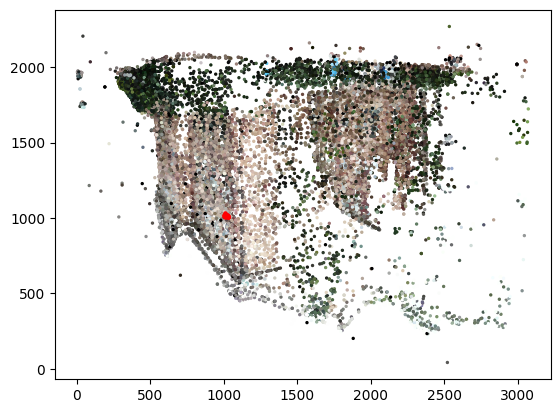

In [58]:
plt.scatter(screen_coordinates[~ids, 0], screen_coordinates[~ids, 1], s=2, c=c[~ids], label='within a tile')
plt.scatter(screen_coordinates[ids, 0], screen_coordinates[ids, 1], s=5, c='red', label='outside')

In [59]:
splat_indexes = np.where(ids == True)[0]
splat_indexes

array([  855,   873,   881,  1701,  4646,  5339,  6304,  6519,  6609,
       14968, 15128, 17410, 18007, 21377, 29822])

In original algorithm we also sort splats by their *z* coordinate  

In [60]:
z_sorted = points_pt[ids, 2].sort()

In [61]:
z_indices = z_sorted.indices.type(torch.int)

In [62]:
points_pt[ids][z_indices] # chosen splats sorted by z coordinate

tensor([[1001.3662, 1018.9285,    6.3706],
        [1006.4678, 1011.2070,    6.3721],
        [1005.0593, 1022.6404,    6.3751],
        [1003.3591, 1014.9602,    6.3752],
        [1004.9012, 1007.0420,    6.3755],
        [1005.8243, 1024.5929,    6.3796],
        [1013.4578, 1020.7559,    6.3861],
        [1023.5832, 1017.4078,    6.3950],
        [1023.4136, 1017.8189,    6.3951],
        [1025.9486, 1005.9556,    6.3960],
        [1029.1620, 1004.7127,    6.3990],
        [1027.9734, 1014.9981,    6.3994],
        [1028.3239, 1003.6096,    6.4009],
        [1029.5161, 1014.3641,    6.4017],
        [1006.3964, 1030.1542,    6.4351]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [63]:
tile_pixels = np.array(list(itertools.product(range(1000, 1000 + tile_size), range(1000, 1000 + tile_size))))

In [64]:
tile_pixels # coordinates of pixels that lie within a chosen tile

array([[1000, 1000],
       [1000, 1001],
       [1000, 1002],
       ...,
       [1031, 1029],
       [1031, 1030],
       [1031, 1031]])

In [65]:
pixel = torch.tensor([coor + 16, coor + 16], device=device) # choose one pixel to be rendered

In [66]:
image_pt = torch.tensor(image / 255.0, device=device) # normalize color

In [67]:
pixel.shape

torch.Size([2])

In [37]:
lambd = 0.2
i = 0
"""
rendered_colors = torch.zeros(len(tile_pixels), 3, device=device, dtype=torch.float32)
for pixel in torch.tensor(tile_pixels, device=device, dtype=torch.float32):
    for g_id in splat_indexes:
        mu = points_pt[g_id]
        r, s = rot[g_id], torch.exp(scale_exponents[g_id]) # apply exponential function accordingly to the paper
        cov = r @ s @ s.T @ r.T
        x_max, x_min, y_max, y_min = get_bounding_box(mu.detach().cpu(), cov.detach().cpu())
        if x_max > pixel[0] > x_min and y_min < pixel[1] < y_max:
            J = torch.tensor([[-znear / mu[2], 0, 0], 
                              [0, -znear / mu[2], 0],
                              [mu[0] / (mu[2] ** 2), mu[1] / (mu[2] ** 2), 0]], requires_grad=requires_grad, device=device, dtype=torch.float32)
            proj_cov = J @ W @ cov @ W.T @ J.T
            det = cov[0, 0] * cov[1, 1] - cov[0, 1] * cov[1, 0]
            inv_cov_2d = 1 / det * torch.tensor([[cov[1, 1], -cov[0, 1]], [-cov[1, 0], cov[0, 0]]], requires_grad=requires_grad, device=device, dtype=torch.float32)
            # apply sigmoid as in the paper
            alpha = alphas_exponents_pt[g_id]
            alpha_sg = torch.sigmoid(alpha)
            g_val = torch.exp(-1/2 * (pixel - mu[:2]).T @ inv_cov_2d @ (pixel - mu[:2]))
            weight = alpha_sg * g_val
            print(f"Weight is {weight}")
            rendered_colors[i] = weight * colors_pt[g_id]
    
    print(f"Rendered color is: {rendered_colors[i]}")
    print(f"Pixel color is: {image_pt[int(pixel[0]), int(pixel[1])]}")
    
    # loss computation and gradient propagation
    loss = (1 - lambd) * torch.sum(abs(rendered_colors[i] - image_pt[pixel[0], pixel[1]])) # + lambd * ssim()
    
    i += 1

# loss = (1 - lambd) * torch.sum(abs(rendered_color - image_pt[pixel[0], pixel[1]])) # + lambd * ssim()"""

'\nrendered_colors = torch.zeros(len(tile_pixels), 3, device=device, dtype=torch.float32)\nfor pixel in torch.tensor(tile_pixels, device=device, dtype=torch.float32):\n    for g_id in splat_indexes:\n        mu = points_pt[g_id]\n        r, s = rot[g_id], torch.exp(scale_exponents[g_id]) # apply exponential function accordingly to the paper\n        cov = r @ s @ s.T @ r.T\n        x_max, x_min, y_max, y_min = get_bounding_box(mu.detach().cpu(), cov.detach().cpu())\n        if x_max > pixel[0] > x_min and y_min < pixel[1] < y_max:\n            J = torch.tensor([[-znear / mu[2], 0, 0], \n                              [0, -znear / mu[2], 0],\n                              [mu[0] / (mu[2] ** 2), mu[1] / (mu[2] ** 2), 0]], requires_grad=requires_grad, device=device, dtype=torch.float32)\n            proj_cov = J @ W @ cov @ W.T @ J.T\n            det = cov[0, 0] * cov[1, 1] - cov[0, 1] * cov[1, 0]\n            inv_cov_2d = 1 / det * torch.tensor([[cov[1, 1], -cov[0, 1]], [-cov[1, 0], cov[0

In [68]:
pixel = torch.tensor([2466, 1360], device=device)

In [69]:
points_pt[1]

tensor([2466.1611, 1360.8909,    6.2887], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [70]:
class JacobianOp(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x, y, z, znear):
        ctx.save_for_backward(x, y, z, znear)
        return torch.tensor([[-znear / z, 0, 0], 
                              [0, -znear / z, 0],
                              [x / (z ** 2), y / (z ** 2), 0]], requires_grad=requires_grad, device=device, dtype=torch.float32)
    
    @staticmethod
    def backward(ctx, grad_output):
        x, y, z, znear = ctx.saved_tensors
        
        x_der = grad_output @ torch.tensor([[0, 0, 0], [0, 0, 0], [1 / z ** 2, 0, 0]], requires_grad=requires_grad, device=device, dtype=torch.float32)
        y_der = grad_output @ torch.tensor([[0, 0, 0], [0, 0, 0], [0, 1 / z ** 2, 0]], requires_grad=requires_grad, device=device, dtype=torch.float32)
        z_der = grad_output @ torch.tensor([[znear / (z ** 2), 0, 0], [0, znear / (z ** 2), 0], [-2 * x / (z ** 2), -2 * y / (z ** 2), 0]], requires_grad=requires_grad, device=device, dtype=torch.float32)
        
        return x_der, y_der, z_der, None
        

In [41]:
"""x, y, z, n = torch.tensor([1, 2, 3, 1], requires_grad=True, device=device, dtype=torch.float32).unbind()
J_op = JacobianOp.apply
result = J_op(x, y, z, n)"""

'x, y, z, n = torch.tensor([1, 2, 3, 1], requires_grad=True, device=device, dtype=torch.float32).unbind()\nJ_op = JacobianOp.apply\nresult = J_op(x, y, z, n)'

In [71]:
znear_pt = torch.scalar_tensor(znear, device=device, dtype=torch.float32)

In [82]:
splat_rot = rot[splat_indexes]

In [83]:
splat_scale = torch.exp(scale_exponents[splat_indexes]).type(torch.float32)

In [85]:
splat_rs = torch.bmm(splat_rot, splat_scale)

In [86]:
torch.bmm(splat_rs, splat_rs.transpose(1, 2))

tensor([[[4.3015, 0.0000, 0.0000],
         [0.0000, 4.3015, 0.0000],
         [0.0000, 0.0000, 4.3015]],

        [[4.9982, 0.0000, 0.0000],
         [0.0000, 4.9982, 0.0000],
         [0.0000, 0.0000, 4.9982]],

        [[4.2237, 0.0000, 0.0000],
         [0.0000, 4.2237, 0.0000],
         [0.0000, 0.0000, 4.2237]],

        [[4.2247, 0.0000, 0.0000],
         [0.0000, 4.2247, 0.0000],
         [0.0000, 0.0000, 4.2247]],

        [[4.9045, 0.0000, 0.0000],
         [0.0000, 4.9045, 0.0000],
         [0.0000, 0.0000, 4.9045]],

        [[4.4570, 0.0000, 0.0000],
         [0.0000, 4.4570, 0.0000],
         [0.0000, 0.0000, 4.4570]],

        [[4.1743, 0.0000, 0.0000],
         [0.0000, 4.1743, 0.0000],
         [0.0000, 0.0000, 4.1743]],

        [[4.1947, 0.0000, 0.0000],
         [0.0000, 4.1947, 0.0000],
         [0.0000, 0.0000, 4.1947]],

        [[4.7718, 0.0000, 0.0000],
         [0.0000, 4.7718, 0.0000],
         [0.0000, 0.0000, 4.7718]],

        [[4.9774, 0.0000, 0.0000],
  

In [87]:
jacs = torch.zeros(len(splat_indexes), 3, 3)

In [88]:
jacs[:, 0, 0] = -znear_pt / points_pt[splat_indexes, 2]

In [43]:
g_id = 1
i = 0
mu = points_pt[g_id].clone().detach().requires_grad_(True)
x, y, z = mu.unbind()
s_exp = scale_exponents[g_id].clone().detach().requires_grad_(True)
r, s = rot[g_id].clone().detach().requires_grad_(True), torch.exp(s_exp) # apply exponential function accordingly to the paper
cov = r @ s @ s.T @ r.T

J_op = JacobianOp.apply
J = J_op(x, y, z, znear_pt)

proj_cov = J @ W @ cov @ W.T @ J.T
inv_cov_2d = torch.linalg.inv(proj_cov[:2, :2])
# apply sigmoid as in the paper
alpha = alphas_exponents_pt[g_id]
alpha_sg = torch.sigmoid(alpha)
g_val = torch.exp(-1/2 * (pixel - mu[:2]).T @ inv_cov_2d @ (pixel - mu[:2]))
weight = alpha_sg * g_val
rendered_color = weight * colors_pt[g_id]

loss = torch.sum(abs(rendered_color - torch.tensor([1, 1, 1], device=device)))

C:\Users\julia\AppData\Local\Temp\ipykernel_21868\4076437865.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3701.)
  g_val = torch.exp(-1/2 * (pixel - mu[:2]).T @ inv_cov_2d @ (pixel - mu[:2]))


In [55]:
rot

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        ...,

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0', requires_grad=True)

In [45]:
loss.backward()

tensor([[3.0229e-02, 1.6713e-01, 1.5720e-09],
        [1.6713e-01, 9.2404e-01, 1.6142e-08],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0')


In [46]:
loss

tensor(2.9767, device='cuda:0', grad_fn=<SumBackward0>)

In [47]:
cov

tensor([[4.9813, 0.0000, 0.0000],
        [0.0000, 4.9813, 0.0000],
        [0.0000, 0.0000, 4.9813]], device='cuda:0', grad_fn=<MmBackward0>)

In [48]:
proj_cov

tensor([[ 1.2596e-01, -1.1848e-09, -4.9396e+01],
        [ 1.1848e-09,  1.2596e-01, -2.7258e+01],
        [-4.9396e+01, -2.7258e+01,  2.5270e+04]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [49]:
inv_cov_2d

tensor([[ 7.9391e+00,  7.4674e-08],
        [-7.4674e-08,  7.9391e+00]], device='cuda:0',
       grad_fn=<LinalgInvExBackward0>)

In [51]:
mu.grad

tensor([0.0298, 0.1649, 0.0326], device='cuda:0')

In [52]:
mu

tensor([2466.1611, 1360.8909,    6.2887], device='cuda:0', requires_grad=True)

In [50]:
pixel - mu[:2]

tensor([-0.1611, -0.8909], device='cuda:0', grad_fn=<SubBackward0>)

In [51]:
rendered_color

tensor([4.2123e-05, 3.9218e-05, 3.1955e-05], device='cuda:0',
       grad_fn=<MulBackward0>)

In [52]:
-1/2 * (pixel - mu[:2]).T @ inv_cov_2d @ (pixel - mu[:2])

tensor(-3.3530, device='cuda:0', grad_fn=<DotBackward0>)

In [53]:
weight

tensor(0.0002, device='cuda:0', grad_fn=<MulBackward0>)

In [54]:
g_val

tensor(0.0350, device='cuda:0', grad_fn=<ExpBackward0>)

In [50]:
alpha_sg

tensor(5.4195, device='cuda:0', grad_fn=<MulBackward0>)

In [59]:
mu.grad

tensor([1.1819e-18, 1.7089e-19, 0.0000e+00], device='cuda:0')

In [47]:
inv_cov_2d

tensor([[4.7289, -0.0000],
        [-0.0000, 4.7289]], device='cuda:0', grad_fn=<MulBackward0>)

In [45]:
g_val

tensor(1.1636e-33, device='cuda:0', grad_fn=<ExpBackward0>)

In [46]:
inv_cov_2d

tensor([[3.9137, -0.0000],
        [-0.0000, 3.9137]], device='cuda:0', grad_fn=<MulBackward0>)

In [47]:
mu.grad

tensor([4.3935e-32, 6.3528e-33, 0.0000e+00], device='cuda:0')

In [65]:
J

tensor([[-0.1590,  0.0000,  0.0000],
        [ 0.0000, -0.1590,  0.0000],
        [62.3598, 34.4117,  0.0000]], device='cuda:0', requires_grad=True)

In [48]:
s_exp

tensor([[-0.6822,    -inf,    -inf],
        [   -inf, -0.6822,    -inf],
        [   -inf,    -inf, -0.6822]], device='cuda:0', requires_grad=True)

In [54]:
s

tensor([[0.5055, 0.0000, 0.0000],
        [0.0000, 0.5055, 0.0000],
        [0.0000, 0.0000, 0.5055]], device='cuda:0', grad_fn=<ExpBackward0>)

In [55]:
print(cov.grad_fn.next_functions)

((<MmBackward0 object at 0x0000020F5E4AEAD0>, 0), (<PermuteBackward0 object at 0x0000020F5E4AC040>, 0))


In [54]:
print(proj_cov.grad_fn.next_functions)

((<MmBackward0 object at 0x0000020F5E4AD180>, 0), (<PermuteBackward0 object at 0x0000020F5E4AD300>, 0))


In [57]:
inv_cov_2d

tensor([[3.9137, -0.0000],
        [-0.0000, 3.9137]], device='cuda:0', grad_fn=<MulBackward0>)

In [58]:
alpha

tensor(-3.6394, device='cuda:0', grad_fn=<SelectBackward0>)

In [59]:
J

tensor([[-0.1590,  0.0000,  0.0000],
        [ 0.0000, -0.1590,  0.0000],
        [62.3598, 34.4117,  0.0000]], device='cuda:0', requires_grad=True)

In [60]:
cov

tensor([[0.2555, 0.0000, 0.0000],
        [0.0000, 0.2555, 0.0000],
        [0.0000, 0.0000, 0.2555]], device='cuda:0', grad_fn=<MmBackward0>)